# Parametric pendulum going chaotic

Warning: this is not Python, but Julia!

In [1]:
using OrdinaryDiffEq
using Plots
# Uncomment for interactive plots
#plotly()

## Generic references

1. http://farside.ph.utexas.edu/teaching/329/lectures/node46.html
2. 10.1103/PhysRevLett.52.705 Suppression of Period Doubling in
   Symmetric Systems James W. Swift and Kurt Wiesenfeld
   Phys. Rev. Lett. 52, 705 – Published 27 February 1984
3. https://link.springer.com/article/10.1007/BF01013307
   McLaughlin, J.B. J Stat Phys (1981) 24: 375. https://doi.org/10.1007/BF01013307
   Period-doubling bifurcations and chaotic motion for a parametrically forced pendulum, 
4. https://content.sciendo.com/view/journals/ijame/20/2/article-p257.xml

## Defining the system

In [2]:
function parpend_eqn(du,u,p,t)
    γ, ω02, h = p
    y, θ = u
    du[1] = -γ*y-ω02*(1+h*cos(2*t))*sin(θ)
    du[2] = y
    nothing
end
function parpend_J(J, u, p, t)
    γ, ω02, h = p
    J[1,1] = -γ
    J[1,2] = -ω02*(1+h*cos(2*t))*cos(u[1])
    J[2,1] = 1
    J[2,2] = 0
    nothing
end
parpend = ODEFunction(parpend_eqn; jac=parpend_J)

(::ODEFunction{true,typeof(parpend_eqn),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,typeof(parpend_J),Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing}) (generic function with 7 methods)

## Doubling way to chaos

This one creates a Poincare cross-section for crossing the plane $\theta=0$, assuming $\theta$ is on the circle.

In [3]:
function poincaresec(u0, p, T, Ttr=0.0, alg=Tsit5();
                     save_everystep=false, save_start=false, save_end=false,
                     reltol=1e-10, abstol=1e-10, dtmax=0.1)
    stored_sinu2 = 1.0
    function poincaresec_cond(u, t, integrator)
        s = sin(u[2]/2)
        if t<Ttr && s!=0
            stored_sinu2 = s
            return 1.0
        else
            return stored_sinu2*s
        end
    end
    poincaresec_cb = ContinuousCallback(poincaresec_cond, int -> nothing,
                                        save_positions = (true, false))
    prob = ODEProblem(parpend, u0, Ttr+T, p)
    sol = solve(prob, alg, callback=poincaresec_cb,
                save_everystep=save_everystep,
                save_start=save_start, save_end=save_end,
                reltol=reltol, abstol=abstol, dtmax=dtmax)
    return sol
end

poincaresec (generic function with 3 methods)

Unexcited

In [4]:
function plot_evolutions(θ0set, dotθ0set, p, T;
        tlim=nothing, plotθ=false)
    pl=plot(layout=4, ylim=(-pi,pi))
    if tlim!=nothing
        xlims!(tlim[1], tlim[2])
    end
    for i in 1:4 
        res = poincaresec([dotθ0set[i]; θ0set[i]], p, 0, T, save_everystep=true)
        plot!(res.t, map(x->x[1],res.u), subplot=i, label="dθ/dt", lw=1)
        if plotθ
            plot!(res.t, map(x->x[2],res.u), subplot=i, label="θ", lw=1)
        end
    end
    xlabel!("t", subplot=3)
    xlabel!("t", subplot=4)
    pl
end

plot_evolutions (generic function with 1 method)

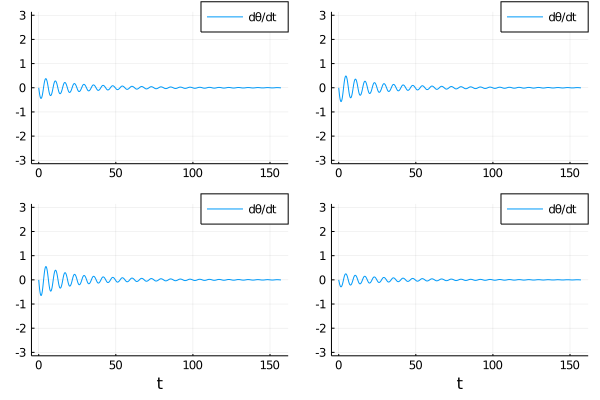

In [5]:
plot_evolutions(rand(4), [0,0,0,0], [0.1, (1.0)^2, 0.1], 50pi)

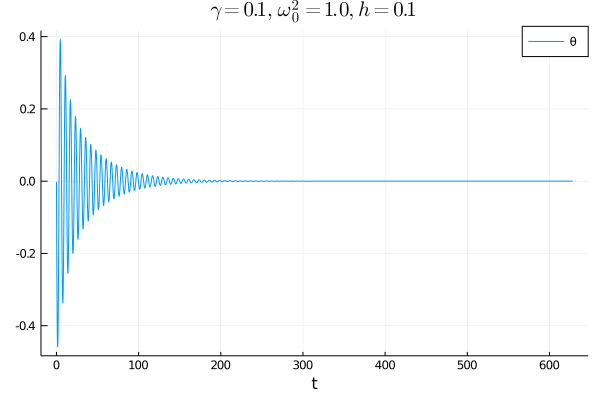

In [6]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 0.1]
res=poincaresec(u0, p, 0π, 200pi, save_everystep=true)
plot(res.t,map(x->x[1],res.u), label="θ")
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
xlabel!("t")

Swinging

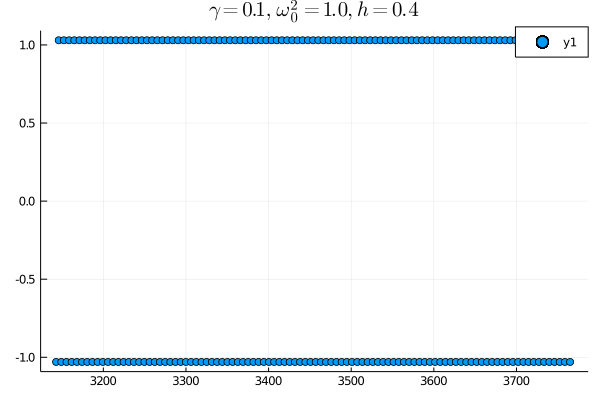

In [7]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 0.4]
res=poincaresec(u0, p, 200π, 1000pi)
scatter(res.t,map(x->x[1],res.u))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")

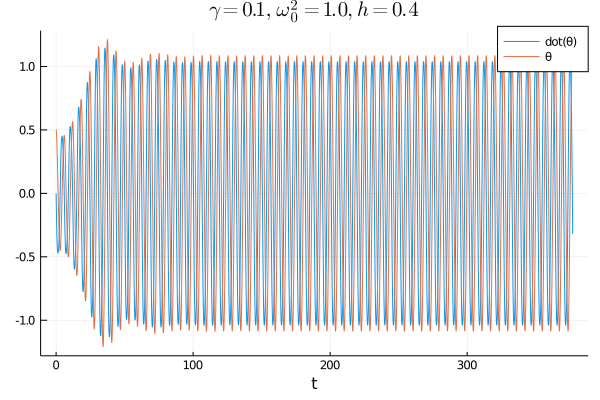

In [8]:
res=poincaresec(u0, p, 20π, 100pi, save_everystep=true)
fi=1
plot(res.t[fi:end].-res.t[fi],map(x->x[1],res.u[fi:end]), label="dot(θ)")
plot!(res.t[fi:end].-res.t[fi],map(x->x[2],res.u[fi:end]), label="θ")
xlabel!("t")
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")

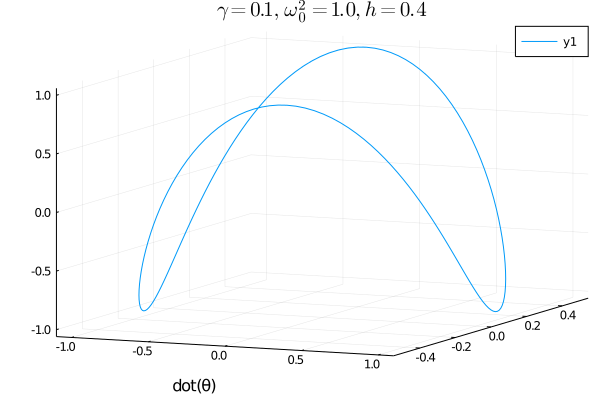

In [9]:
res=poincaresec(u0, p, 20π, 100pi, save_everystep=true)
fi=findfirst(res.t.>100pi)
plot(map(x->x[1],res.u[fi:end]), map(x->sin(x[2]/2),res.u[fi:end]),
    cos.(2*res.t[fi:end]), zlabel="cos(2t)", xaxis=("dot(θ)"), yaxis=("sin(θ/2)"))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")

Symmetry breaking -- note, that on top of symmetry breaking motion the period for velocity is halved $T=\pi$ (equal to driving frequency).

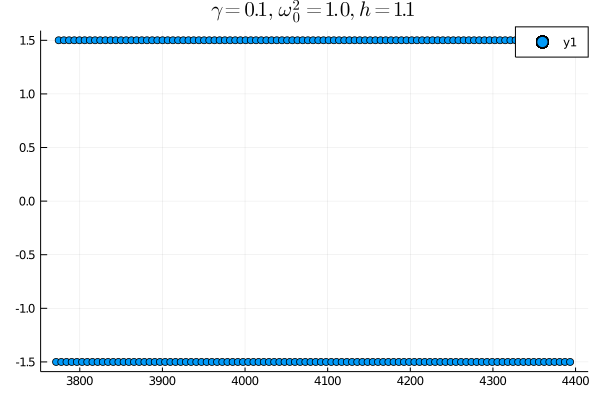

In [10]:
u0 = [0; 0.1]
p = [0.1, (1.0)^2, 1.1]
res=poincaresec(u0, p, 200π, 1200pi)
scatter(res.t,map(x->x[1],res.u))
#plot(res.t,map(x->x[2],res.u))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")

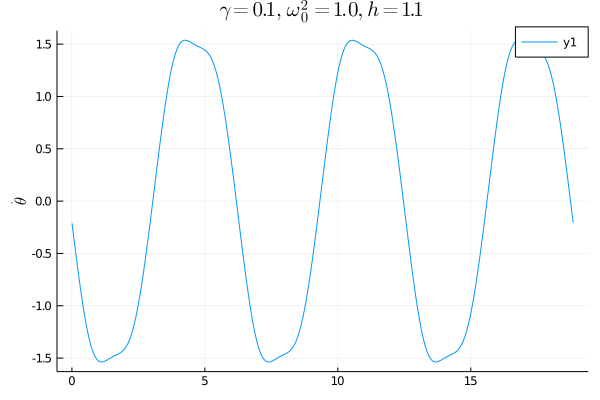

In [11]:
res=poincaresec(u0, p, 6π, 1200pi, save_everystep=true)
plot(res.t[res.t.>1200pi].-1200pi,map(x->x[1],res.u[res.t.>1200pi]))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
ylabel!("\$\\dot\\theta\$")
#plot(res.t[res.t.>1200pi].-1200pi,map(x->x[2],res.u[res.t.>1200pi]).+7000)

Period doubling

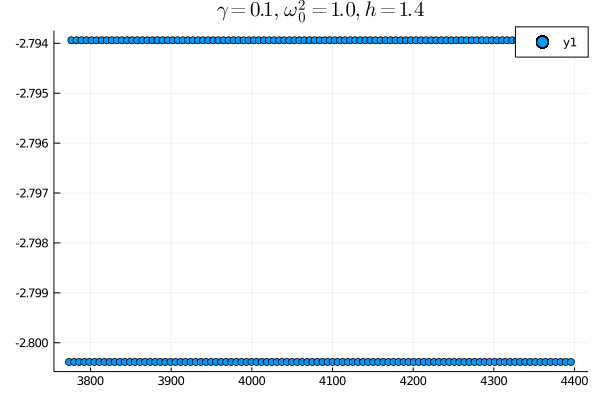

In [12]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 1.4]
res=poincaresec(u0, p, 200π, 1200pi)
#plt.clf()
scatter(res.t,map(x->x[1],res.u))
#plot(res.t,map(x->x[2],res.u))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#plt.gcf()

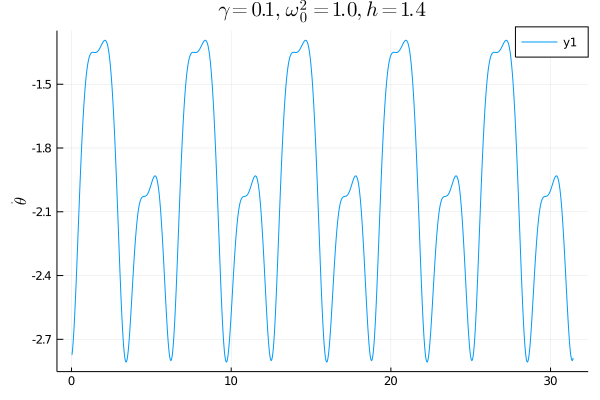

In [13]:
res=poincaresec(u0, p, 10π, 1200pi, save_everystep=true)
#clf()
fi=findfirst(res.t.>1200pi)
plot(res.t[fi:end].-1200pi,map(x->x[1],res.u[fi:end]))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
ylabel!("\$\\dot\\theta\$")
#plot(res.t[fi:end].-1200pi,map(x->x[2],res.u[fi:end]).-res[2,fi])
#gcf()

In [14]:
res=poincaresec(u0, p, 20π, 1200pi, save_everystep=true)
#clf()
fi=findfirst(res.t.>1200pi)
plot(map(x->x[1],res.u[fi:end]), map(x->sin(x[2]/2),res.u[fi:end]),
       cos.(2*res.t[fi:end]))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
xlabel!("dot(θ)"); ylabel!("sin(θ/2)");
#plt.zlabel("cos(2t)")

Period 4

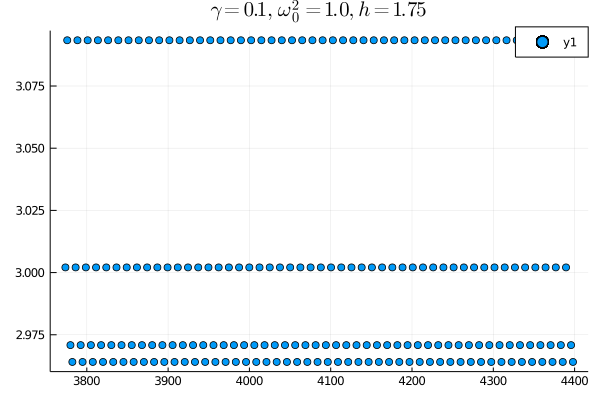

In [15]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 1.75]
res=poincaresec(u0, p, 200π, 1200pi)
#clf()
scatter(res.t,map(x->x[1],res.u))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#plot(res.t,map(x->x[2],res.u))
#gcf()

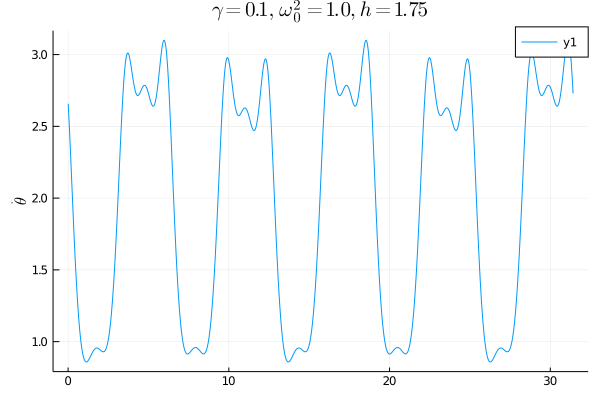

In [16]:
res=poincaresec(u0, p, 10π, 1200pi, save_everystep=true)
#clf()
fi=findfirst(res.t.>1200pi)
#fi=1
plot(res.t[fi:end].-1200pi,map(x->x[1],res.u[fi:end]))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
ylabel!("\$\\dot\\theta\$")
#plot(res.t[fi:end].-1200pi,map(x->x[2],res.u[fi:end]).-res[2,fi])
#gcf()

Period 8? May be integrator precision?

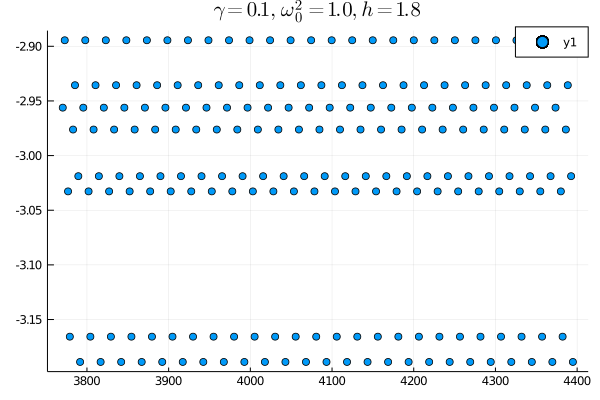

In [17]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 1.8]
res=poincaresec(u0, p, 200π, 1200pi, Vern7(), reltol=1e-13, dtmax=0.01)
#clf()
scatter(res.t,map(x->x[1],res.u))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#plot(res.t,map(x->x[2],res.u))
#gcf()

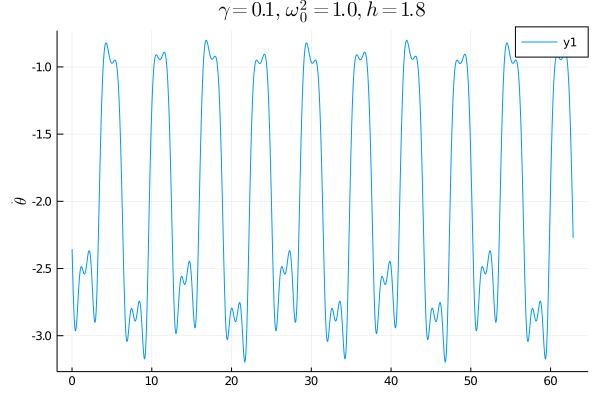

In [18]:
res=poincaresec(u0, p, 20π, 1200pi, Vern7(), reltol=1e-13, dtmax=0.01, save_everystep=true)
#clf()
fi=findfirst(res.t.>1200pi)
plot(res.t[fi:end].-1200pi,map(x->x[1],res.u[fi:end]))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
ylabel!("\$\\dot\\theta\$")
#plot(res.t[fi:end].-1200pi,map(x->x[2],res.u[fi:end]).-res[2,fi])
#gcf()

Chaos?

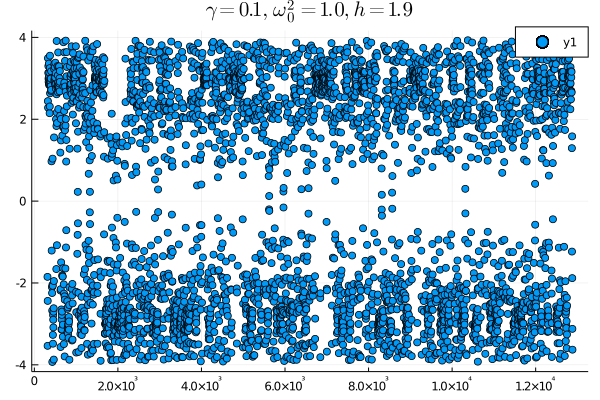

In [19]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 1.9]
res=poincaresec(u0, p, 4000π, 100pi)
#clf()
scatter(res.t,map(x->x[1],res.u))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#plot(res.t,map(x->x[2],res.u))
#gcf()

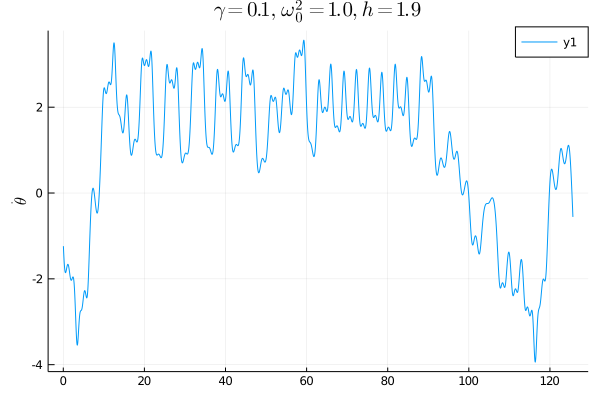

In [20]:
res=poincaresec(u0, p, 40π, 100pi, save_everystep=true)
#plt.clf()
fi=findfirst(res.t.>100pi)
plot(res.t[fi:end].-100pi,map(x->x[1],res.u[fi:end]))
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
ylabel!("\$\\dot\\theta\$")
#plot(res.t[fi:end].-1200pi,map(x->x[2],res.u[fi:end]).-res[2,fi])
#gcf()

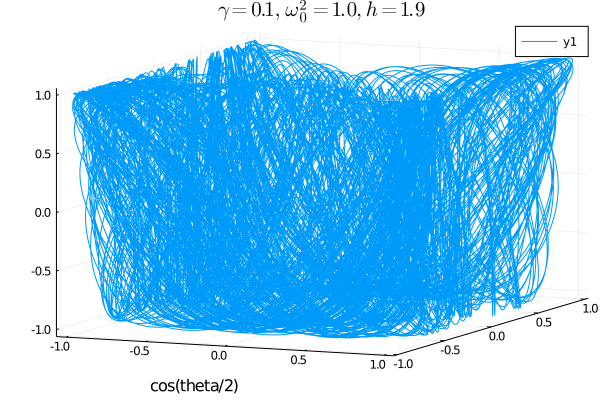

In [21]:
Ttr=330pi
res=poincaresec(u0, p, 500π, Ttr,save_everystep=true)
#clf()
fi=findfirst(res.t.>Ttr)
plot(map(x->cos(x[2]/2),res.u[fi:end]),
       map(x->x[1]/4,res.u[fi:end]), 
    cos.(2*res.t[fi:end]),
xlabel="cos(theta/2)",ylabel="dot(theta)",zlabel="cos(2t)")
title!("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#gcf()

## Takens Embedding

In [22]:
function delaysec(delay, u0, p, T, Ttr=0.0, alg=Tsit5();
                     reltol=1e-10, abstol=1e-10, dtmax=0.1)
    prob1 = ODEProblem(parpend, u0, Ttr, p)
    sol1 = solve(prob1, alg, save_on=false, save_end=true, reltol=reltol, abstol=abstol, dtmax=dtmax)
    prob = ODEProblem(parpend, sol1[end], (Ttr, Ttr+T), p)
    sol = solve(prob, alg,
                saveat=delay,
                reltol=reltol, abstol=abstol, dtmax=dtmax)
    return sol
end

delaysec (generic function with 3 methods)

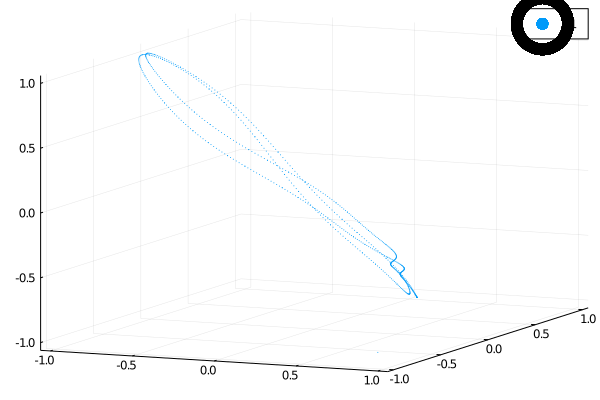

In [23]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 0.4]
p = [0.1, (1.0)^2, 1.75]
#p = [0.1, (1.0)^2, 1.9]
res=delaysec(2, u0, p, 1500π, 400pi);

len3=div(length(res),3)*3
#plot3d((res[1,1:3:len3]),(res[1,2:3:len3]),(res[1,3:3:len3]))
scatter3d(cos.(res[2,1:3:len3]/2),cos.(res[2,2:3:len3]/2),cos.(res[2,3:3:len3]/2), ms=0.1)

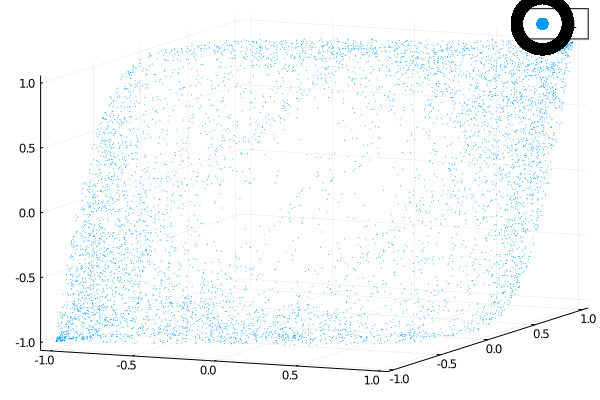

In [24]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 0.4]
p = [0.1, (1.0)^2, 1.75]
p = [0.1, (1.0)^2, 1.9]
res=delaysec(0.9, u0, p, 5500π, 1000pi);

len3=div(length(res),3)*3
#scatter3d((res[1,1:3:len3]),(res[1,2:3:len3]),(res[1,3:3:len3]), ms=0.1)
p=scatter3d(cos.(res[2,1:3:len3]/2),cos.(res[2,2:3:len3]/2),cos.(res[2,3:3:len3]/2), ms=0.1)
#savefig(p,"t.html")
p

## Kapitza's pendulum case


Upside down position $\theta=\pi$ is stable for $h^2>8/\omega_0^2/\omega^2$. See
https://en.wikipedia.org/wiki/Kapitza%27s_pendulum

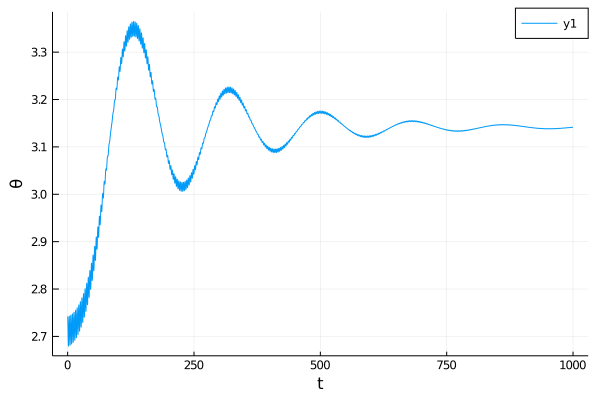

In [25]:
u0 = [0.0; π-0.4]
tspan = 1000.0
p = [0.01, (0.1)^2, 30.0]
prob = ODEProblem(parpend, u0, tspan, p)
sol = solve(prob, Tsit5(), reltol=1e-13, abstol=1e-13, dtmax=0.1*2*π)
#clf()
plot(sol.t, map(x->x[2],sol.u))
ylabel!("θ"); xlabel!("t")
#gcf()